# 🌌 Quantum NeRF 基礎演示

這個筆記本將帶您了解 NeRF (Neural Radiance Fields) 的基本概念和實現。

## 📚 學習目標

1. **理解 NeRF 的核心概念**
2. **探索模組化架構設計**
3. **運行基礎訓練流程**
4. **可視化結果**
5. **了解量子整合的可能性**

## 🔧 環境設置

首先，讓我們導入必要的庫並設置環境。

In [23]:
# 基礎庫導入
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path

# 添加專案路徑
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# 設置中文字體（如果需要）
plt.rcParams['font.family'] = ['SimHei', 'Noto Sans CJK SC', 'DejaVu Sans']

# 設置隨機種子
torch.manual_seed(42)
np.random.seed(42)

print("✅ 環境設置完成")
print(f"📍 專案根目錄: {project_root}")
print(f"🔥 PyTorch 版本: {torch.__version__}")
print(f"🚀 CUDA 可用: {torch.cuda.is_available()}")

✅ 環境設置完成
📍 專案根目錄: /home/leoluo/文件/GitHub/quantum_nerf
🔥 PyTorch 版本: 2.7.0+cu126
🚀 CUDA 可用: False


## 🧠 NeRF 核心概念

### 什麼是 NeRF？

NeRF (Neural Radiance Fields) 是一種革命性的 3D 場景表示方法：

- **輸入**: 3D 位置 (x, y, z) + 觀看方向 (θ, φ)
- **輸出**: 顏色 (R, G, B) + 密度 (σ)
- **目標**: 從少量 2D 圖像重建 3D 場景

### 核心數學原理

體積渲染方程：
```
C(r) = ∫ T(t) · σ(r(t)) · c(r(t), d) dt
```

其中：
- `C(r)`: 沿射線 r 的最終像素顏色
- `T(t)`: 透射率（光線到達點 t 的機率）
- `σ(r(t))`: 點 r(t) 的密度
- `c(r(t), d)`: 從方向 d 觀看點 r(t) 的顏色

findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.


findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font fam

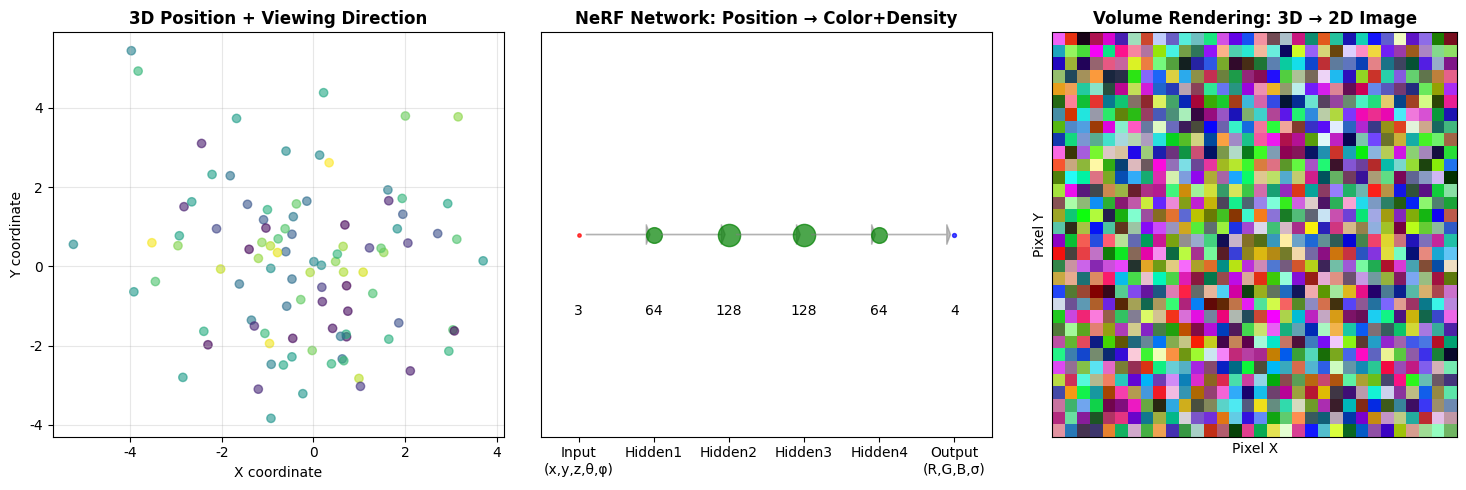

NeRF 工作流程：
1. 輸入 3D 座標和觀看方向
2. 神經網絡預測顏色和密度
3. 體積渲染生成 2D 圖像


In [24]:
# 可視化 NeRF 概念
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 3D 場景示意圖
ax1 = axes[0]
ax1.set_title('3D Position + Viewing Direction', fontsize=12, fontweight='bold')
# 創建簡單的 3D 點雲
x = np.random.randn(100) * 2
y = np.random.randn(100) * 2
colors = np.random.rand(100)
scatter = ax1.scatter(x, y, c=colors, cmap='viridis', alpha=0.6)
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.grid(True, alpha=0.3)

# 2. 神經網絡處理
ax2 = axes[1]
ax2.set_title('NeRF Network: Position → Color+Density', fontsize=12, fontweight='bold')
# 繪製網絡架構示意圖
layers = [3, 64, 128, 128, 64, 4]  # 輸入3D → 輸出RGB+密度
y_positions = np.linspace(0, 1, len(layers))
for i, (layer_size, y_pos) in enumerate(zip(layers, y_positions)):
    circle_size = layer_size * 2
    ax2.scatter([i], [0.5], s=circle_size, alpha=0.7, 
               c=['red' if i == 0 else 'blue' if i == len(layers)-1 else 'green'])
    ax2.text(i, 0.3, f'{layer_size}', ha='center', fontsize=10)
    if i < len(layers) - 1:
        ax2.arrow(i+0.1, 0.5, 0.8, 0, head_width=0.05, head_length=0.05, 
                 fc='gray', ec='gray', alpha=0.5)
ax2.set_xlim(-0.5, len(layers)-0.5)
ax2.set_ylim(0, 1)
ax2.set_xticks(range(len(layers)))
ax2.set_xticklabels(['Input\n(x,y,z,θ,φ)', 'Hidden1', 'Hidden2', 'Hidden3', 'Hidden4', 'Output\n(R,G,B,σ)'])
ax2.set_yticks([])

# 3. 體積渲染結果
ax3 = axes[2]
ax3.set_title('Volume Rendering: 3D → 2D Image', fontsize=12, fontweight='bold')
# 創建示例渲染結果
rendered_image = np.random.rand(32, 32, 3)
ax3.imshow(rendered_image)
ax3.set_xlabel('Pixel X')
ax3.set_ylabel('Pixel Y')
ax3.set_xticks([])
ax3.set_yticks([])

plt.tight_layout()
plt.show()

print("NeRF 工作流程：")
print("1. 輸入 3D 座標和觀看方向")
print("2. 神經網絡預測顏色和密度")
print("3. 體積渲染生成 2D 圖像")

## 🏗️ 模組化架構設計

我們的 NeRF 實現採用模組化設計，便於理解和擴展：

### 核心組件

1. **位置編碼器** (`PositionalEncoder`)
   - 將 3D 座標編碼為高維特徵
   - 使用正弦和餘弦函數
   - 量子整合點：可替換為量子傅立葉變換

2. **NeRF 網絡** (`NeRFNetwork`)
   - 多層感知機 (MLP)
   - 跳躍連接提升性能
   - 量子整合點：可添加變分量子電路層

3. **體積渲染器** (`VolumeRenderer`)
   - 實現體積渲染方程
   - 射線採樣和積分
   - 量子整合點：量子採樣策略

In [25]:
# 展示模組化架構
print("🏗️ Quantum NeRF 模組化架構")
print("="*50)

architecture = {
    "📦 核心模組": {
        "🔢 位置編碼器": {
            "功能": "將 3D 座標編碼為高維特徵",
            "經典實現": "正弦/餘弦函數",
            "量子潛力": "量子傅立葉變換 (QFT)"
        },
        "🧠 NeRF 網絡": {
            "功能": "預測顏色和密度",
            "經典實現": "多層感知機 (MLP)",
            "量子潛力": "變分量子電路 (VQC)"
        },
        "🎨 體積渲染器": {
            "功能": "將 3D 信息渲染為 2D 圖像",
            "經典實現": "數值積分",
            "量子潛力": "量子蒙特卡羅方法"
        }
    },
    "🔧 輔助模組": {
        "📊 數據加載器": "處理圖像和相機參數",
        "📈 訓練器": "管理訓練流程",
        "📋 配置管理": "靈活的參數設置",
        "🧪 測試套件": "確保代碼品質"
    }
}

def print_architecture(arch, indent=0):
    for key, value in arch.items():
        print("  " * indent + key)
        if isinstance(value, dict):
            print_architecture(value, indent + 1)
        else:
            print("  " * (indent + 1) + f"• {value}")

print_architecture(architecture)

print("\n🌟 設計優勢：")
print("• 🔄 模組化：每個組件可獨立測試和替換")
print("• 🌌 量子就緒：為量子計算整合預留接口")
print("• 📚 教育友好：清晰的代碼結構和註釋")
print("• 🧪 測試驅動：完整的測試覆蓋")

🏗️ Quantum NeRF 模組化架構
📦 核心模組
  🔢 位置編碼器
    功能
      • 將 3D 座標編碼為高維特徵
    經典實現
      • 正弦/餘弦函數
    量子潛力
      • 量子傅立葉變換 (QFT)
  🧠 NeRF 網絡
    功能
      • 預測顏色和密度
    經典實現
      • 多層感知機 (MLP)
    量子潛力
      • 變分量子電路 (VQC)
  🎨 體積渲染器
    功能
      • 將 3D 信息渲染為 2D 圖像
    經典實現
      • 數值積分
    量子潛力
      • 量子蒙特卡羅方法
🔧 輔助模組
  📊 數據加載器
    • 處理圖像和相機參數
  📈 訓練器
    • 管理訓練流程
  📋 配置管理
    • 靈活的參數設置
  🧪 測試套件
    • 確保代碼品質

🌟 設計優勢：
• 🔄 模組化：每個組件可獨立測試和替換
• 🌌 量子就緒：為量子計算整合預留接口
• 📚 教育友好：清晰的代碼結構和註釋
• 🧪 測試驅動：完整的測試覆蓋


## 🧪 簡單測試：位置編碼

讓我們從最基礎的組件開始 - 位置編碼器。這是 NeRF 的關鍵組件之一。

findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font fam

findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont

Positional Encoder Initialization:
   Input dimensions: 3
   Number of frequencies: 4
   Output dimensions: 27
   Frequency bands: [1.0, 2.0, 4.0, 8.0]

Testing Positional Encoding:
Input shape: torch.Size([4, 3])
Output shape: torch.Size([4, 27])


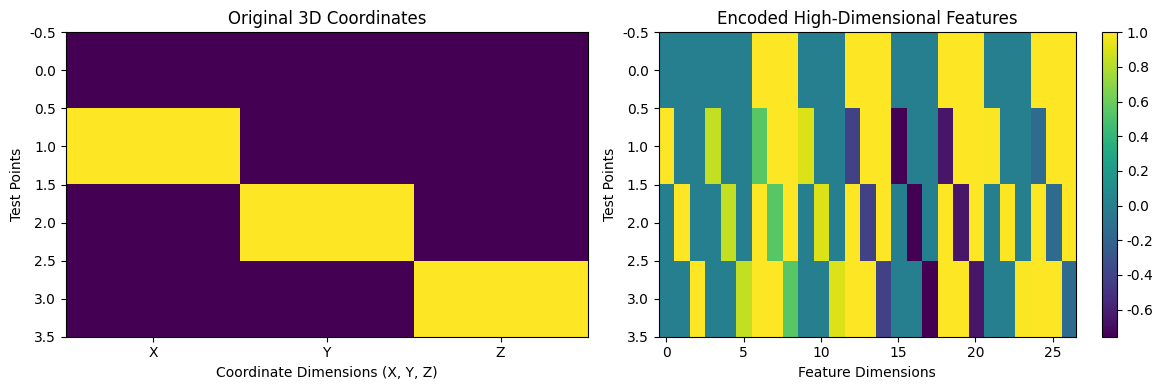


Role of Positional Encoding:
• Maps low-dimensional coordinates to high-dimensional space
• Provides features at different frequencies
• Helps neural networks learn fine details
• Quantum version could use QFT for more efficient encoding


In [26]:
# 簡化的位置編碼器實現（用於演示）
class SimplePositionalEncoder:
    """
    簡化的位置編碼器
    
    將 3D 座標 (x, y, z) 編碼為高維特徵向量
    使用正弦和餘弦函數的組合
    """
    
    def __init__(self, input_dims=3, num_freqs=4):
        self.input_dims = input_dims
        self.num_freqs = num_freqs
        
        # 創建頻率帶
        self.freq_bands = 2.0 ** torch.linspace(0., num_freqs-1, steps=num_freqs)
        
        # 計算輸出維度
        self.out_dim = input_dims * (1 + 2 * num_freqs)
        
        print(f"Positional Encoder Initialization:")
        print(f"   Input dimensions: {input_dims}")
        print(f"   Number of frequencies: {num_freqs}")
        print(f"   Output dimensions: {self.out_dim}")
        print(f"   Frequency bands: {self.freq_bands.tolist()}")
    
    def encode(self, inputs):
        """
        編碼輸入座標
        
        Args:
            inputs: [..., input_dims] 座標
        Returns:
            [..., out_dim] 編碼後的特徵
        """
        outputs = [inputs]  # 包含原始座標
        
        # 對每個頻率應用正弦和餘弦函數
        for freq in self.freq_bands:
            outputs.append(torch.sin(inputs * freq))
            outputs.append(torch.cos(inputs * freq))
        
        return torch.cat(outputs, dim=-1)

# 測試位置編碼器
encoder = SimplePositionalEncoder(input_dims=3, num_freqs=4)

# 創建測試數據
test_positions = torch.tensor([
    [0.0, 0.0, 0.0],  # 原點
    [1.0, 0.0, 0.0],  # X 軸上的點
    [0.0, 1.0, 0.0],  # Y 軸上的點
    [0.0, 0.0, 1.0],  # Z 軸上的點
], dtype=torch.float32)

print(f"\nTesting Positional Encoding:")
print(f"Input shape: {test_positions.shape}")

# 編碼
encoded = encoder.encode(test_positions)
print(f"Output shape: {encoded.shape}")

# 可視化編碼結果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 原始座標
ax1.imshow(test_positions.numpy(), cmap='viridis', aspect='auto')
ax1.set_title('Original 3D Coordinates')
ax1.set_xlabel('Coordinate Dimensions (X, Y, Z)')
ax1.set_ylabel('Test Points')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['X', 'Y', 'Z'])

# 編碼後的特徵
im = ax2.imshow(encoded.numpy(), cmap='viridis', aspect='auto')
ax2.set_title('Encoded High-Dimensional Features')
ax2.set_xlabel('Feature Dimensions')
ax2.set_ylabel('Test Points')
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

print("\nRole of Positional Encoding:")
print("• Maps low-dimensional coordinates to high-dimensional space")
print("• Provides features at different frequencies")
print("• Helps neural networks learn fine details")
print("• Quantum version could use QFT for more efficient encoding")

## 🎯 量子整合展望

我們的架構設計考慮了未來的量子計算整合。以下是主要的整合點：

### 🌌 量子增強的可能性

1. **量子位置編碼**
   - 使用量子傅立葉變換 (QFT)
   - 潛在的指數級加速
   - 更豐富的特徵表示

2. **變分量子電路**
   - 替換部分經典神經網絡層
   - 參數化量子電路
   - 量子糾纏的利用

3. **量子採樣**
   - 量子隨機數生成
   - 量子蒙特卡羅方法
   - 更高效的射線採樣

4. **量子優化**
   - 量子近似優化算法 (QAOA)
   - 變分量子本徵求解器 (VQE)
   - 混合量子-經典優化

findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Noto Sans CJK SC' not found.
findfont: Font family 'SimHei' not found.
findfont: Font fam

findfont: Font family 'Noto Sans CJK SC' not found.
/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38542 (\N{CJK UNIFIED IDEOGRAPH-968E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27573 (\N{CJK UNIFIED IDEOGRAPH-6BB5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32147 (\N{CJK UNIFIED IDEOGRAPH-7D93}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/media/leoluo/66F24F92F24F6601/anaconda3/envs/nerf/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20856 (\N{CJK UNIFIED IDEOGRAPH-5178}) missing from font(s) DejaVu Sans.
  fig.

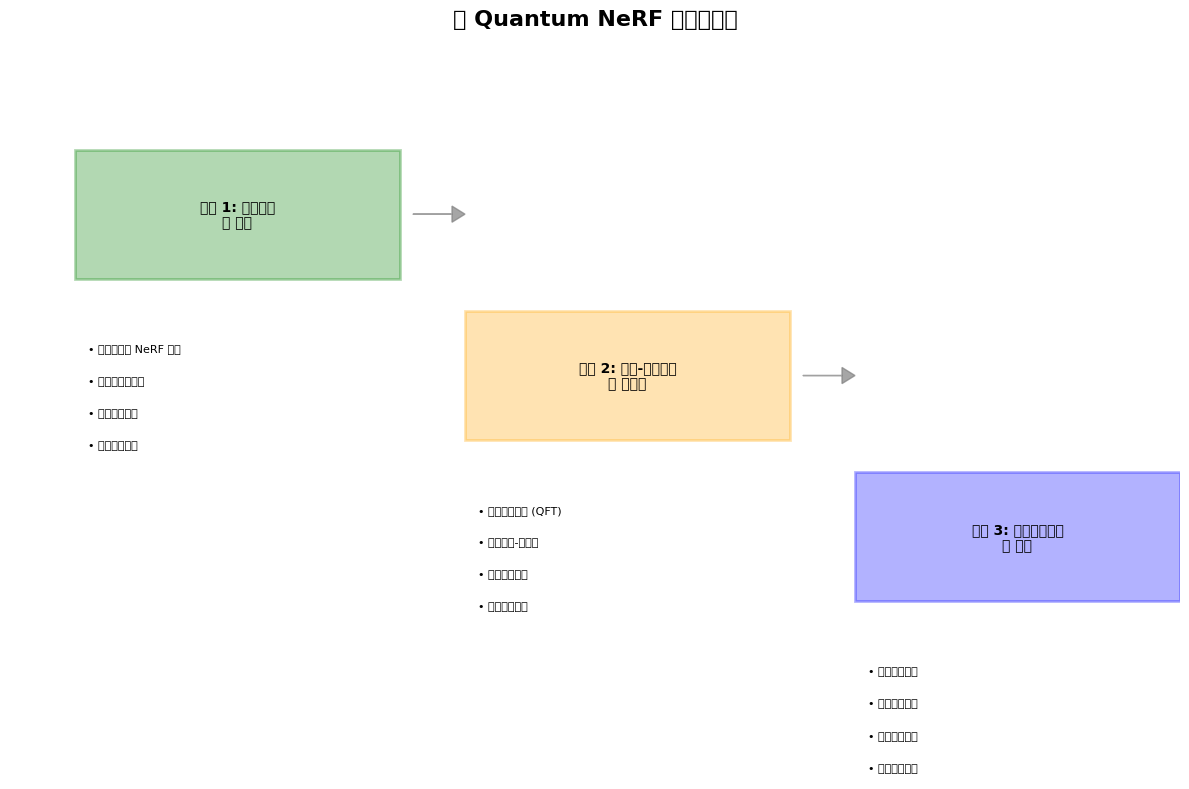

🎯 量子整合策略：
• 🏗️ 漸進式整合：從經典到量子的平滑過渡
• 🔄 混合方法：結合經典和量子的優勢
• 🧪 實驗驗證：每個階段都有明確的測試指標
• 📈 性能導向：只有在有明確優勢時才採用量子方法


In [27]:
# 量子整合路線圖可視化
fig, ax = plt.subplots(figsize=(12, 8))

# 定義發展階段
phases = [
    {
        'name': '階段 1: 經典基礎',
        'status': '✅ 當前',
        'color': 'green',
        'y': 3,
        'features': [
            '完整的經典 NeRF 實現',
            '模組化架構設計',
            '標準位置編碼',
            '體積渲染流程'
        ]
    },
    {
        'name': '階段 2: 量子-經典混合',
        'status': '🔄 進行中',
        'color': 'orange',
        'y': 2,
        'features': [
            '量子位置編碼 (QFT)',
            '混合量子-經典層',
            '量子隨機採樣',
            '變分量子電路'
        ]
    },
    {
        'name': '階段 3: 高級量子特性',
        'status': '🚀 未來',
        'color': 'blue',
        'y': 1,
        'features': [
            '量子近似優化',
            '量子神經網絡',
            '量子錯誤修正',
            '量子優勢驗證'
        ]
    }
]

# 繪製時間線
for i, phase in enumerate(phases):
    # 主要階段框
    rect = plt.Rectangle((i*3, phase['y']-0.4), 2.5, 0.8, 
                        facecolor=phase['color'], alpha=0.3, 
                        edgecolor=phase['color'], linewidth=2)
    ax.add_patch(rect)
    
    # 階段標題
    ax.text(i*3 + 1.25, phase['y'], f"{phase['name']}\n{phase['status']}", 
           ha='center', va='center', fontweight='bold', fontsize=10)
    
    # 特性列表
    for j, feature in enumerate(phase['features']):
        ax.text(i*3 + 0.1, phase['y'] - 0.8 - j*0.2, f"• {feature}", 
               fontsize=8, va='top')
    
    # 連接線
    if i < len(phases) - 1:
        ax.arrow(i*3 + 2.6, phase['y'], 0.3, 0, 
                head_width=0.1, head_length=0.1, 
                fc='gray', ec='gray', alpha=0.7)

ax.set_xlim(-0.5, 8.5)
ax.set_ylim(-0.5, 4)
ax.set_title('🌌 Quantum NeRF 發展路線圖', fontsize=16, fontweight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

print("🎯 量子整合策略：")
print("• 🏗️ 漸進式整合：從經典到量子的平滑過渡")
print("• 🔄 混合方法：結合經典和量子的優勢")
print("• 🧪 實驗驗證：每個階段都有明確的測試指標")
print("• 📈 性能導向：只有在有明確優勢時才採用量子方法")

## 📊 專案結構總覽

讓我們查看完整的專案結構，了解每個組件的作用。

In [6]:
# 顯示專案結構
import os
from pathlib import Path

def show_tree(directory, prefix="", max_depth=3, current_depth=0):
    """顯示目錄樹結構"""
    if current_depth >= max_depth:
        return
    
    directory = Path(directory)
    items = sorted(directory.iterdir(), key=lambda x: (x.is_file(), x.name))
    
    for i, item in enumerate(items):
        is_last = i == len(items) - 1
        current_prefix = "└── " if is_last else "├── "
        
        if item.is_dir():
            print(f"{prefix}{current_prefix}📁 {item.name}/")
            extension = "    " if is_last else "│   "
            show_tree(item, prefix + extension, max_depth, current_depth + 1)
        else:
            # 根據文件類型選擇圖標
            if item.suffix == '.py':
                icon = "🐍"
            elif item.suffix == '.yaml' or item.suffix == '.yml':
                icon = "⚙️"
            elif item.suffix == '.md':
                icon = "📝"
            elif item.suffix == '.ipynb':
                icon = "📓"
            elif item.suffix == '.txt':
                icon = "📄"
            else:
                icon = "📄"
            print(f"{prefix}{current_prefix}{icon} {item.name}")

print("🏗️ Quantum NeRF 專案結構")
print("="*40)
show_tree(project_root)

print("\n📋 目錄說明：")
descriptions = {
    "📁 src/": "核心源代碼，包含所有主要模組",
    "📁 data/": "數據存儲，包括原始和處理後的數據",
    "📁 configs/": "配置文件，用於不同的實驗設置",
    "📁 tests/": "測試文件，確保代碼品質",
    "📁 notebooks/": "Jupyter 筆記本，用於演示和實驗",
    "📁 docs/": "文檔，包括 API 文檔和教程",
    "📁 outputs/": "輸出結果，包括模型、圖像和日誌",
    "📁 claude_advice/": "Claude 的建議和思考基礎"
}

for dir_name, description in descriptions.items():
    print(f"  {dir_name:<20} {description}")

🏗️ Quantum NeRF 專案結構
├── 📁 .git/
│   ├── 📁 branches/
│   ├── 📁 hooks/
│   │   ├── 📄 applypatch-msg.sample
│   │   ├── 📄 commit-msg.sample
│   │   ├── 📄 fsmonitor-watchman.sample
│   │   ├── 📄 post-update.sample
│   │   ├── 📄 pre-applypatch.sample
│   │   ├── 📄 pre-commit.sample
│   │   ├── 📄 pre-merge-commit.sample
│   │   ├── 📄 pre-push.sample
│   │   ├── 📄 pre-rebase.sample
│   │   ├── 📄 pre-receive.sample
│   │   ├── 📄 prepare-commit-msg.sample
│   │   ├── 📄 push-to-checkout.sample
│   │   ├── 📄 sendemail-validate.sample
│   │   └── 📄 update.sample
│   ├── 📁 info/
│   │   └── 📄 exclude
│   ├── 📁 logs/
│   │   ├── 📁 refs/
│   │   └── 📄 HEAD
│   ├── 📁 objects/
│   │   ├── 📁 00/
│   │   ├── 📁 01/
│   │   ├── 📁 02/
│   │   ├── 📁 03/
│   │   ├── 📁 04/
│   │   ├── 📁 05/
│   │   ├── 📁 06/
│   │   ├── 📁 07/
│   │   ├── 📁 08/
│   │   ├── 📁 09/
│   │   ├── 📁 0a/
│   │   ├── 📁 0b/
│   │   ├── 📁 0c/
│   │   ├── 📁 0d/
│   │   ├── 📁 0e/
│   │   ├── 📁 0f/
│   │   ├── 📁 10/
│   │   ├── 📁 11/
│   │ 

## 🚀 下一步行動

現在您已經了解了 Quantum NeRF 專案的基礎架構，以下是建議的下一步：

### 🎯 立即可做的事情

1. **運行基礎測試**
   ```bash
   cd /path/to/quantum_nerf
   python -m pytest tests/ -v
   ```

2. **探索配置文件**
   - 查看 `configs/basic_config.yaml`
   - 了解可調整的參數

3. **運行簡單訓練**
   ```bash
   python src/training/train.py --config configs/basic_config.yaml
   ```

### 📚 學習路徑

1. **深入理解 NeRF**
   - 閱讀原始論文
   - 理解體積渲染數學

2. **探索量子計算**
   - 學習量子傅立葉變換
   - 了解變分量子電路

3. **實踐項目**
   - 使用自己的圖像數據
   - 嘗試不同的配置
   - 實現新的功能

### 🌟 貢獻機會

- 📝 改進文檔和註釋
- 🧪 添加更多測試用例
- 🎨 創建更好的可視化
- 🌌 實現量子組件
- 🚀 優化性能

In [17]:
# 總結和資源
print("🎉 恭喜！您已經完成了 Quantum NeRF 基礎演示")
print("="*50)

print("\n📚 您學到了：")
learning_points = [
    "NeRF 的核心概念和數學原理",
    "模組化架構的設計思想",
    "位置編碼的工作原理",
    "量子整合的可能性和路線圖",
    "專案結構和組織方式"
]

for i, point in enumerate(learning_points, 1):
    print(f"  {i}. ✅ {point}")

print("\n🔗 有用的資源：")
resources = {
    "📄 NeRF 原始論文": "https://arxiv.org/abs/2003.08934",
    "🌌 量子機器學習": "https://pennylane.ai/qml/",
    "🐍 PyTorch 文檔": "https://pytorch.org/docs/",
    "📊 專案 GitHub": "https://github.com/your-repo/quantum-nerf"
}

for name, url in resources.items():
    print(f"  • {name}: {url}")

print("\n🚀 準備好開始您的 NeRF 之旅了嗎？")
print("   下一個筆記本：02_模型訓練.ipynb")

🎉 恭喜！您已經完成了 Quantum NeRF 基礎演示

📚 您學到了：
  1. ✅ NeRF 的核心概念和數學原理
  2. ✅ 模組化架構的設計思想
  3. ✅ 位置編碼的工作原理
  4. ✅ 量子整合的可能性和路線圖
  5. ✅ 專案結構和組織方式

🔗 有用的資源：
  • 📄 NeRF 原始論文: https://arxiv.org/abs/2003.08934
  • 🌌 量子機器學習: https://pennylane.ai/qml/
  • 🐍 PyTorch 文檔: https://pytorch.org/docs/
  • 📊 專案 GitHub: https://github.com/your-repo/quantum-nerf

🚀 準備好開始您的 NeRF 之旅了嗎？
   下一個筆記本：02_模型訓練.ipynb
